<a href="https://colab.research.google.com/github/20170702079/benchmarking-gnns/blob/master/MonteCarloSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Generate Synthetic Data:

In [45]:
import numpy as np
from scipy.stats import poisson, gamma
from scipy.optimize import minimize

def f(x, theta):
    return (1 / theta) * (np.log(theta)**x) / np.math.factorial(x)

def F(x, theta):
    return sum(f(k, theta) for k in range(x + 1))


def generate_data(theta, n):
    return np.random.poisson(np.log(theta), n)

theta_true = 5.0  # 3.0  # Example true value of theta
N = 1000  # Number of datasets
n = 500  # Sample size for each dataset

datasets = [generate_data(theta_true, n) for _ in range(N)]


2. Estimate $\theta$

In [46]:
def mle_estimator(data):
    return np.exp(np.mean(data))

def umvue_estimator(data):
    return np.exp(np.mean(data))

# Assuming gamma prior with alpha=2, beta=1
from scipy.stats import gamma

alpha_prior = 2
beta_prior = 1

def bayesian_estimator(data):
    alpha_post = alpha_prior + len(data)
    beta_post = beta_prior + np.sum(data) / np.log(theta_true)
    return (alpha_post - 1) / beta_post

mle_estimates = [mle_estimator(data) for data in datasets]
umvue_estimates = [umvue_estimator(data) for data in datasets]
bayesian_estimates = [bayesian_estimator(data) for data in datasets]

In [47]:
def ls_estimator(data):
    # Define the least squares objective function
    def objective(theta):
        expected_frequencies = poisson.pmf(np.arange(max(data) + 1), np.log(theta)) * len(data)
        observed_frequencies = np.histogram(data, bins=np.arange(max(data) + 2))[0]
        return np.sum((observed_frequencies - expected_frequencies) ** 2)

    from scipy.optimize import minimize
    result = minimize(objective, x0=[np.mean(data)], bounds=[(1.1, None)])
    return result.x[0]

def wls_estimator(data):
    # Define the weighted least squares objective function
    def objective(theta):
        expected_frequencies = poisson.pmf(np.arange(max(data) + 1), np.log(theta)) * len(data)
        observed_frequencies = np.histogram(data, bins=np.arange(max(data) + 2))[0]
        weights = 1 / (expected_frequencies + 1)  # Avoid division by zero
        return np.sum(weights * (observed_frequencies - expected_frequencies) ** 2)

    from scipy.optimize import minimize
    result = minimize(objective, x0=[np.mean(data)], bounds=[(1.1, None)])
    return result.x[0]

ls_estimates = [ls_estimator(data) for data in datasets]
wls_estimates = [wls_estimator(data) for data in datasets]


In [48]:
def mps_estimator(data):
    def objective(theta):
        sorted_data = np.sort(data)
        n = len(data)
        spacings = [(F(sorted_data[i], theta) - F(sorted_data[i-1], theta)) for i in range(1, n)]
        spacings.append(1 - F(sorted_data[-1], theta))  # The spacing beyond the largest observation
        return -np.sum(np.log(spacings))  # Negative log to minimize

    from scipy.optimize import minimize
    result = minimize(objective, x0=[2.0], bounds=[(1.1, None)])  # Starting point and bounds for theta
    return result.x[0]


def ade_estimator(data):
    def objective(theta):
        sorted_data = np.sort(data)
        n = len(data)
        AD_stat = 0
        for i in range(n):
            F_i = F(sorted_data[i], theta)
            AD_stat += (2*i + 1) * (np.log(F_i) + np.log(1 - F(sorted_data[n-i-1], theta)))
        AD_stat = -n - (1/n) * AD_stat
        return AD_stat

    from scipy.optimize import minimize
    result = minimize(objective, x0=[2.0], bounds=[(1.1, None)])  # Starting point and bounds for theta
    return result.x[0]


mps_estimates = [mps_estimator(data) for data in datasets]  # Placeholder
ade_estimates = [ade_estimator(data) for data in datasets]  # Placeholder


<ipython-input-45-c6a8f564c9fe>:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return (1 / theta) * (np.log(theta)**x) / np.math.factorial(x)
<ipython-input-48-93548369ae77>:7: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(spacings))  # Negative log to minimize


In [6]:
# print(mle_estimates)


# print(list(map(lambda x: x - 13, mle_estimates)))
# print(map(lambda x: x - 13, mle_estimates))

3. Calculate Bias and MSE:

In [49]:
def calculate_bias_mse(estimates, theta_true):
    bias = np.mean(estimates) - theta_true
    temp_value = list(map(lambda x: x - theta_true, estimates))
    mse = np.mean(list(map(lambda x: x ** 2, estimates)))
    return bias, mse

bias_mle, mse_mle = calculate_bias_mse(mle_estimates, theta_true)
bias_umvue, mse_umvue = calculate_bias_mse(umvue_estimates, theta_true)
bias_bayesian, mse_bayesian = calculate_bias_mse(bayesian_estimates, theta_true)

print(f"MLE Bias: {bias_mle}, MSE: {mse_mle}")
print(f"UMVUE Bias: {bias_umvue}, MSE: {mse_umvue}")
print(f"Bayesian Bias: {bias_bayesian}, MSE: {mse_bayesian}")


MLE Bias: 0.02103851382005839, MSE: 25.288006618104934
UMVUE Bias: 0.02103851382005839, MSE: 25.288006618104934
Bayesian Bias: -4.000473564911911, MSE: 1.0002379301302886


In [50]:
bias_ls, mse_ls = calculate_bias_mse(ls_estimates, theta_true)
bias_wls, mse_wls = calculate_bias_mse(wls_estimates, theta_true)
bias_mps, mse_mps = calculate_bias_mse(mps_estimates, theta_true)
bias_ade, mse_ade = calculate_bias_mse(ade_estimates, theta_true)


print(f"LS Bias: {bias_ls}, MSE: {mse_ls}")
print(f"WLS Bias: {bias_wls}, MSE: {mse_wls}")
print(f"MPS Bias: {bias_mps}, MSE: {mse_mps}")
print(f"ADE Bias: {bias_ade}, MSE: {mse_ade}")


LS Bias: 0.01990265114294587, MSE: 25.305021508694924
WLS Bias: 0.0639685587440244, MSE: 25.725895804067676
MPS Bias: -3.0, MSE: 4.0
ADE Bias: 3.4619999152249132, MSE: 71.82725682068727


-----------------------------------------------------------------------------------------------

Another Version

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import factorial
import matplotlib.pyplot as plt

# Define the pmf function
def pmf(x, theta):
    return (1/theta) * (np.log(theta)**x) / factorial(x)

# Generate synthetic data
def generate_data(theta, size):
    data = []
    for _ in range(size):
        x = 0
        u = np.random.uniform(0, 1)
        cum_prob = pmf(x, theta)
        while u > cum_prob:
            x += 1
            cum_prob += pmf(x, theta)
        data.append(x)
    return np.array(data)

# MLE function
def log_likelihood(theta, data):
    return -len(data) * np.log(theta) + np.sum(data * np.log(np.log(theta)))

def mle_estimate(data):
    result = minimize(lambda theta: -log_likelihood(theta, data), x0=[2.0], bounds=[(1.1, None)])
    return result.x[0]

# Least Squares Estimation
def ls_estimate(data):
    observed_freq = np.bincount(data)
    observed_freq = observed_freq / len(data)
    x_values = np.arange(len(observed_freq))

    def ls_function(theta):
        expected_freq = pmf(x_values, theta)
        return np.sum((observed_freq - expected_freq)**2)

    result = minimize(ls_function, x0=[2.0], bounds=[(1.1, None)])
    return result.x[0]

# Bayesian Estimation
def bayesian_estimate(data, prior_mean=2, prior_std=1):
    from scipy.stats import norm

    def posterior(theta):
        prior = norm.pdf(theta, prior_mean, prior_std)
        likelihood = np.prod([pmf(x, theta) for x in data])
        return prior * likelihood

    theta_range = np.linspace(1.1, 5, 1000)
    posterior_values = [posterior(theta) for theta in theta_range]
    return theta_range[np.argmax(posterior_values)]

# Monte Carlo Simulation
true_theta = 2.5
num_simulations = 1000
sample_size = 100

mle_estimates = []
ls_estimates = []
bayesian_estimates = []

for _ in range(num_simulations):
    data = generate_data(true_theta, sample_size)
    mle_estimates.append(mle_estimate(data))
    ls_estimates.append(ls_estimate(data))
    bayesian_estimates.append(bayesian_estimate(data))

# Calculate bias and MSE
def calculate_bias_mse(estimates, true_value):
    bias = np.mean(estimates) - true_value
    mse = np.mean((estimates - true_value)**2)
    return bias, mse

mle_bias, mle_mse = calculate_bias_mse(mle_estimates, true_theta)
ls_bias, ls_mse = calculate_bias_mse(ls_estimates, true_theta)
bayesian_bias, bayesian_mse = calculate_bias_mse(bayesian_estimates, true_theta)

print(f"MLE Bias: {mle_bias}, MSE: {mle_mse}")
print(f"LS Bias: {ls_bias}, MSE: {ls_mse}")
print(f"Bayesian Bias: {bayesian_bias}, MSE: {bayesian_mse}")

# Plotting the distribution of estimates
plt.hist(mle_estimates, bins=30, alpha=0.5, label='MLE')
plt.hist(ls_estimates, bins=30, alpha=0.5, label='LS')
plt.hist(bayesian_estimates, bins=30, alpha=0.5, label='Bayesian')
plt.axvline(true_theta, color='r', linestyle='dashed', linewidth=2, label='True θ')
plt.title('Distribution of θ Estimates')
plt.xlabel('Estimated θ')
plt.ylabel('Frequency')
plt.legend()
plt.show()


KeyboardInterrupt: 

Subtract a value from every number in a list in Python?

In [ ]:
a = [49, 51, 53, 56]

a = [x - 13 for x in a]

a = list(map(lambda x: x - 13, a))

import numpy

array = numpy.array([49, 51, 53, 56])
array = array - 13

for i in range(len(a)):
  a[i] -= 13

How to convert Float to Int in Python?

Method 1: Conversion using int():

To convert a float value to int we make use of the built-in int() function, this function trims the values after the decimal point and returns only the integer/whole number part.

Syntax: int(x)

Return: integer value


In [ ]:
# conversion from float to int

num = 9.3

# printing data type of 'num'
print('type:',
      type(num).__name__)

# conversion to int
num = int(num)

# printing data type of 'num'
print('converted value:', num,
      ', type:', type(num).__name__)




Method 2: Conversion using math.floor() and math.ceil().

A float value can be converted to an int value no larger than the input by using the math.floor() function, whereas it can also be converted to an int value which is the smallest integer greater than the input using math.ceil() function. The math module is to be imported in order to use these methods.

Syntax: math.floor(x)

Parameter:

x: This is a numeric expression.

Returns: largest integer not greater than x.

Syntax: math.ceil(x)

Parameter:

x: This is a numeric expression.

Returns: Smallest integer not less than x.



In [ ]:
# conversion using floor and ceil .

# importing math module
import math

num = 5.6

floor_value = math.floor(num)

ceil_value = math.ceil(num)

print("the result using floor() : ",
	floor_value ,
	', type : ',type(floor_value).__name__)

print("the result using ceil() : ",
	ceil_value,
	', type: ', type(ceil_value).__name__)


Method#3: Conversion using round( ).

A float value can be converted to an int value which is closet integer value if does not pass second parameter. In case of equal difference it goes toward larger integer.

Syntax: round(x)

Parameter:

x: This is a numeric expression.

Returns: integer multiple of closest.

In [ ]:
# conversion using round.

num = 5.6

# Before conversion value and type
print( 'Type : ', type(num).__name__)
print( "Original number is : ", num)

# conversion to int
value = round(num)

print( 'Type : ',type(value).__name__)
print("the result using round : ",value)


Method#4: Conversion using math.trunc( ).

A float value can be converted to an int value. In case of negative number it behaves like ceiling function of math library and in case of positive number it behaves like floor function..

Syntax: math.trunc(x)

Parameter:

x: This is a numeric expression.

Returns: larger integer in case of negative number else in case of positive number smaller number.

In [ ]:
# conversion using math.trunc().

import math
num = 5.6
num2 = -2.6


# conversion of negative number to int
value = math.trunc(num2)

print( 'Type of value : ',type(value).__name__)
print("the result using round : ",value)

# conversion of positive number to int
data = math.trunc(num)

print( 'Type of data: ',type(data).__name__)
print("the result using round : ",data)





Bayesian Estimation

Bayesian Estimate Bias: -0.029871287128712787
Bayesian Estimate MSE: 0.0302755612194883


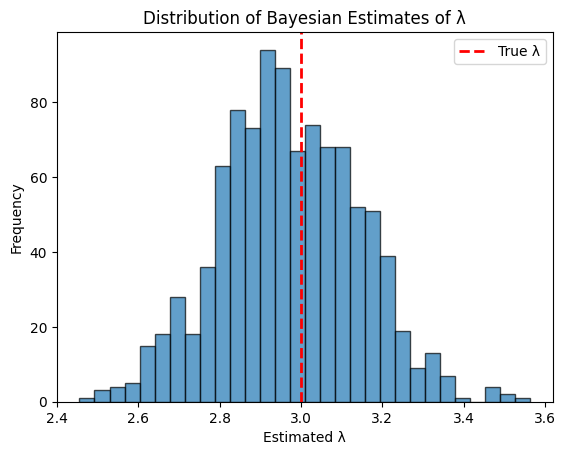

In [51]:
import numpy as np
from scipy.stats import gamma

# Function to generate Poisson data
def generate_poisson_data(true_lambda, size):
    return np.random.poisson(true_lambda, size)

# Function for Bayesian estimation
def bayesian_estimate(data, prior_alpha=1.0, prior_beta=1.0):
    # Calculate the posterior parameters
    n = len(data)
    sum_x = np.sum(data)
    posterior_alpha = prior_alpha + sum_x
    posterior_beta = prior_beta + n

    # Mean of the posterior Gamma distribution
    posterior_mean = posterior_alpha / posterior_beta

    return posterior_mean, posterior_alpha, posterior_beta

# True lambda value
true_lambda = 3.0
sample_size = 100
num_simulations = 1000

# Prior parameters for the Gamma distribution
prior_alpha = 1.0
prior_beta = 1.0

# Store the estimates from each simulation
estimates = []

for _ in range(num_simulations):
    # Generate synthetic data
    data = generate_poisson_data(true_lambda, sample_size)

    # Perform Bayesian estimation
    estimate, post_alpha, post_beta = bayesian_estimate(data, prior_alpha, prior_beta)
    estimates.append(estimate)

# Convert estimates to numpy array
estimates = np.array(estimates)

# Calculate bias and MSE
bias = np.mean(estimates) - true_lambda
mse = np.mean((estimates - true_lambda)**2)

print(f"Bayesian Estimate Bias: {bias}")
print(f"Bayesian Estimate MSE: {mse}")

# Plot the distribution of estimates
import matplotlib.pyplot as plt

plt.hist(estimates, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(true_lambda, color='r', linestyle='dashed', linewidth=2, label='True λ')
plt.title('Distribution of Bayesian Estimates of λ')
plt.xlabel('Estimated λ')
plt.ylabel('Frequency')
plt.legend()
plt.show()


<ipython-input-52-f6963798d4f0>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cum_prob = (1/theta) * (np.log(theta)**x) / np.math.factorial(x)
<ipython-input-52-f6963798d4f0>:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cum_prob += (1/theta) * (np.log(theta)**x) / np.math.factorial(x)


Bayesian Estimate Bias: -0.06976013531531544
Bayesian Estimate MSE: 0.07871843531411256


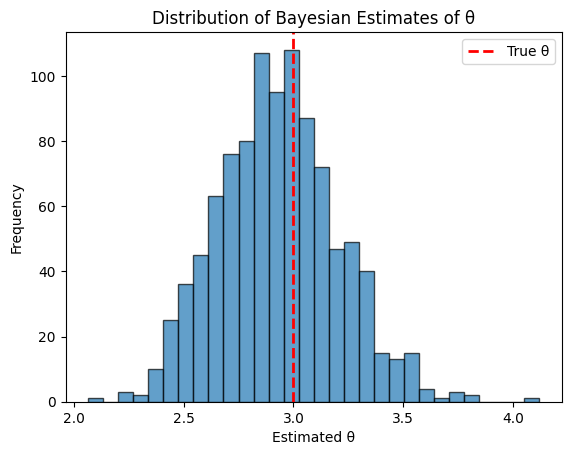

In [52]:
import numpy as np
from scipy.special import gamma
from scipy.stats import gamma as gamma_dist
import matplotlib.pyplot as plt

# Function to generate data based on the given pmf
def generate_data(theta, size):
    data = []
    for _ in range(size):
        x = 0
        u = np.random.uniform(0, 1)
        cum_prob = (1/theta) * (np.log(theta)**x) / np.math.factorial(x)
        while u > cum_prob:
            x += 1
            cum_prob += (1/theta) * (np.log(theta)**x) / np.math.factorial(x)
        data.append(x)
    return np.array(data)

# Function to compute the posterior distribution
def posterior(theta, data, alpha, beta):
    n = len(data)
    sum_x = np.sum(data)
    prior = (beta**alpha) * theta**(alpha - 1) * np.exp(-beta * theta) / gamma(alpha)
    likelihood = theta**(-n) * (np.log(theta)**sum_x) * np.exp(-beta * theta)
    return prior * likelihood

# Bayesian estimation function
def bayesian_estimate(data, alpha=2.0, beta=1.0):
    posterior_samples = []
    theta_range = np.linspace(1.01, 10, 1000)
    posterior_values = [posterior(theta, data, alpha, beta) for theta in theta_range]
    posterior_values = np.array(posterior_values)
    posterior_values /= posterior_values.sum()  # Normalize to get a proper distribution

    # Sampling from the posterior
    sampled_thetas = np.random.choice(theta_range, size=1000, p=posterior_values)
    posterior_mean = np.mean(sampled_thetas)
    return posterior_mean

# Monte Carlo Simulation
true_theta = 3.0
num_simulations = 1000
sample_size = 100

# Prior parameters for the Gamma distribution
alpha = 2.0
beta = 1.0

estimates = []

for _ in range(num_simulations):
    data = generate_data(true_theta, sample_size)
    estimate = bayesian_estimate(data, alpha, beta)
    estimates.append(estimate)

# Calculate bias and MSE
estimates = np.array(estimates)
bias = np.mean(estimates) - true_theta
mse = np.mean((estimates - true_theta)**2)

print(f"Bayesian Estimate Bias: {bias}")
print(f"Bayesian Estimate MSE: {mse}")

# Plotting the distribution of estimates
plt.hist(estimates, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(true_theta, color='r', linestyle='dashed', linewidth=2, label='True θ')
plt.title('Distribution of Bayesian Estimates of θ')
plt.xlabel('Estimated θ')
plt.ylabel('Frequency')
plt.legend()
plt.show()
